# Lab 5: Сегментація зображень. Стиснення/кодування зображення.
### Шевченко Юлія, ФІ-31мн

In this homework, you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise, the objective quality will be worse, but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour palette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [1]:
# All the imports for the task
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

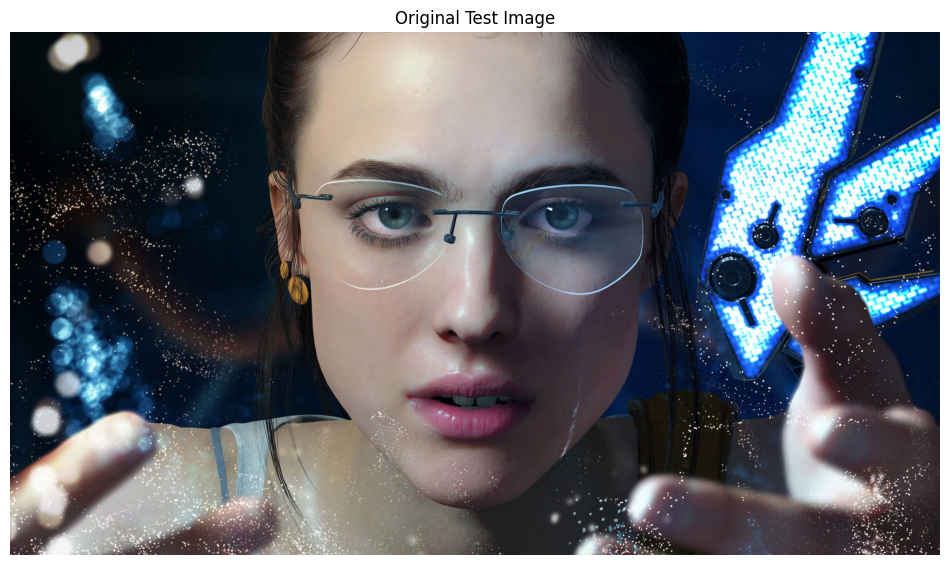

In [2]:
# Loading the test image
image_path = '../Lab_5/test_img.jpg'
image = cv2.imread(image_path)

# Convert BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.title('Original Test Image')
plt.axis('off')
plt.show()

Let's start with gray tones first.

In [3]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

Using the color palette, let's quantize the original image.

In [4]:
def quantize_image(img, palette):
    # Cast the image to float
    img = img.astype(float)

    # Prepare for quantization
    rows, cols, channels = img.shape
    quantized = np.zeros_like(img)

    # Apply quantization
    for r in range(rows):
        for c in range(cols):
            # Extract the original pixel value
            pixel = img[r, c, :]

            # Find the closest color from the palette (using absolute value/Euclidean distance)
            distances = np.sum((palette - pixel) ** 2, axis=1)
            closest_color_index = np.argmin(distances)
            new_pixel = palette[closest_color_index]

            # Apply quantization
            quantized[r, c, :] = new_pixel

    return quantized

In [5]:
quantized_image = quantize_image(image, colors)

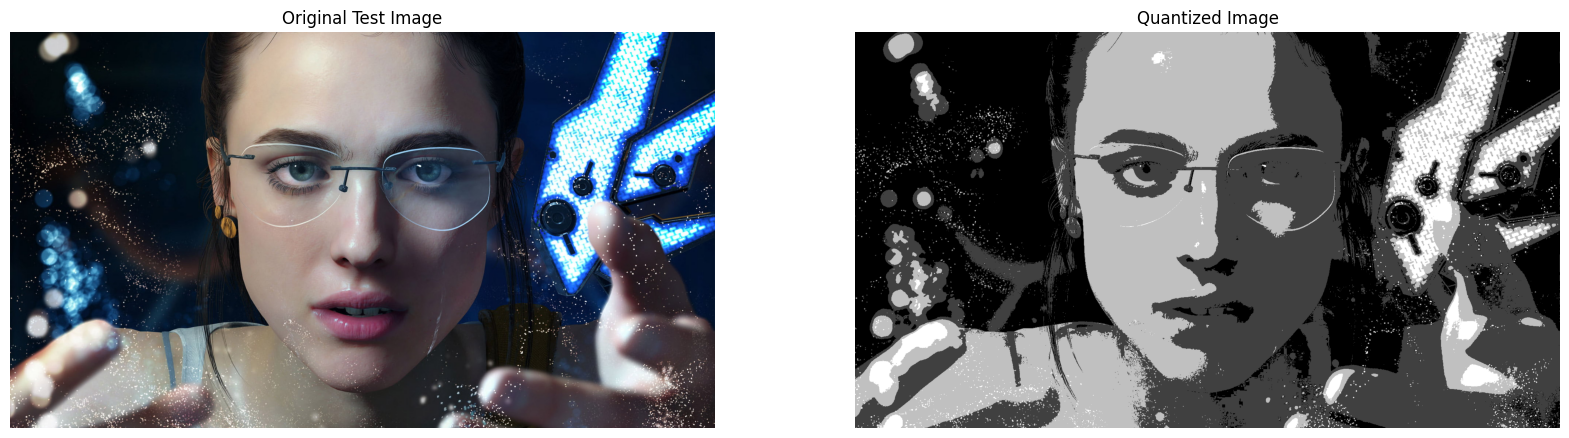

In [6]:
# Show quantized image (remember to cast back to uint8)
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

# Plot the original image
axes[0].imshow(image.astype(np.uint8))
axes[0].set_title('Original Test Image')
axes[0].axis('off')

# Plot the quantized image
axes[1].imshow(quantized_image.astype(np.uint8))
axes[1].set_title('Quantized Image')
axes[1].axis('off')

plt.show()

In [7]:
avg_quant_error = np.mean(np.abs(image - quantized_image))

print('Average quantization error: {}'.format(avg_quant_error))

Average quantization error: 24.535866769547326


#### Floyd-Steinberg Dithering

We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [8]:
def dither_image(img, palette):
    # Make a temporal copy of the original image, we will need it for error diffusion
    img_tmp = img.astype(float)  # Cast to float
    dithering = np.zeros_like(img)

    # Define the Floyd-Steinberg diffusion matrix
    fs_matrix = np.array([[0, 0, 7/16],
                          [3/16, 5/16, 1/16]])

    rows, cols, _ = img.shape

    for r in range(1, rows-1):
        for c in range(1, cols-1):
            # Extract the original pixel value
            pixel = img_tmp[r, c, :]

            # Find the closest color from the palette (using absolute value/Euclidean distance)
            distances = np.sum((palette - pixel) ** 2, axis=1)
            closest_color_index = np.argmin(distances)
            new_pixel = palette[closest_color_index]

            # Compute quantization error
            quant_error = pixel - new_pixel

            # Diffuse the quantization error according to the FS diffusion matrix
            for dr in range(-1, 2):
                for dc in range(-1, 2):
                    if abs(dr) == 1 and abs(dc) == 1:
                        diffusion_factor = fs_matrix[1, 1]
                    else:
                        diffusion_factor = fs_matrix[abs(dr), abs(dc)]

                    img_tmp[r + dr, c + dc, :] += quant_error * diffusion_factor

            # Apply dithering
            dithering[r, c, :] = new_pixel

    return dithering

In [9]:
dithered_image = dither_image(image, colors)

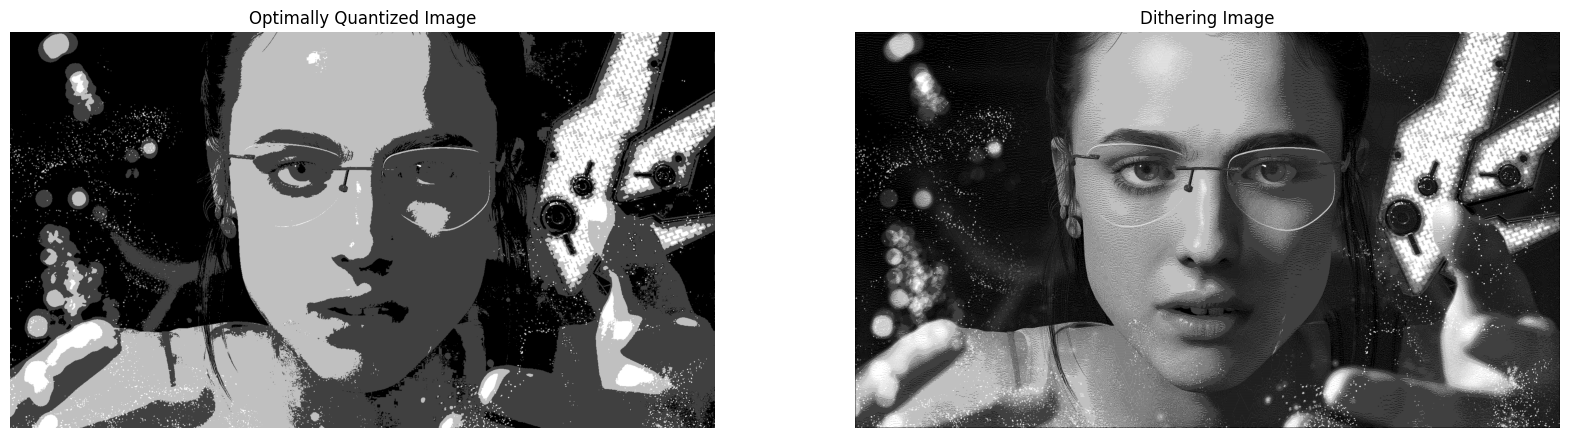

In [10]:
# Show quantized image (remember to cast back to uint8)
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

# Plot the original image
axes[0].imshow(quantized_image.astype(np.uint8))
axes[0].set_title('Optimally Quantized Image')
axes[0].axis('off')

# Plot the quantized image
axes[1].imshow(dithered_image.astype(np.uint8))
axes[1].set_title('Dithering Image')
axes[1].axis('off')

plt.show()

In [11]:
# Compute average quantization error for dithered image
avg_dith_error = np.mean(np.abs(image - dithered_image))

print('Average quantization error for dithered image: {}'.format(avg_dith_error))

Average quantization error for dithered image: 121.48885497042181


## Questions

**Which image has higher quantization error? Optimally quantized or dithered?**

To determine which image has a higher quantization error, we need to compare `avg_quant_error` and `avg_dith_error` to identify which is higher. The image with the higher average quantization error will have more noticeable discrepancies between the original and quantized/dithered versions. We can run the code below:

In [12]:
print('{} Image has higher quantization error'.format('Optimally Quantized' if avg_quant_error > avg_dith_error else 'Dithered'))

Dithered Image has higher quantization error


**Which image looks better to you?**

In comparing the two images, I find the dithered image to be particularly captivating due to its enhanced detail and realism. The method of dithering has effectively introduced subtle variations in tone, resulting in a visually engaging image with intricate textures and nuances.

However, it's important to note that the optimally quantized image also possesses its own allure. While it may not exhibit the same level of detail as the dithered counterpart, its clean and smooth transitions between colors lend it a certain elegance and simplicity. In the context of artistic endeavors, such as poster design, the optimally quantized image could serve as a striking visual element, offering a refined and polished aesthetic.

Furthermore, considering the potential for expanding the color palette used in quantization, the optimally quantized approach presents an opportunity for exploration. By incorporating a broader range of colors, it could potentially bridge the gap between the richness of the dithered image and the precision of the optimally quantized one, offering a versatile solution suitable for a variety of creative applications.

Ultimately, the choice between the dithered and optimally quantized images depends on the specific context and desired aesthetic outcome. Both approaches offer distinct visual experiences, each with its own merits and potential for artistic expression.

**Can you repeat the same process using only two colours: black and white? Show me :-)**